In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
alpha = 0.05

## Task 8.10

For the cyclical data of Table 5.8, do the following:

+ (a) Find the discriminant function coefficient vector.
+ (b) Find the standardized coefficients.
+ (c) Calculate $t-tests$ for individual variables.
+ (d) Compare the results of (b) and (c) as to the contribution of each variable to separation of the groups.
+ (e) Find the partial $F$ for each variable, as in (8.26). Do the partial $F$’s rank the variables in the same order of importance as the standardized coefficients?

In [3]:
data = np.loadtxt('T5_8_GOODS.dat', dtype=float)[:, 1:]
data.shape

(19, 5)

In [4]:
data_group1 = data[data[:, 0] == 1][:, 1:]
data_group2 = data[data[:, 0] == 2][:, 1:]

n1, d1 = data_group1.shape
n2, d2 = data_group2.shape

k = len(np.unique(data[:, 0]))

assert d1 == d2
assert n1 + n2 - 2 > d2

In [5]:
y1_mean = np.mean(data_group1, axis=0)[:, None]
y2_mean = np.mean(data_group2, axis=0)[:, None]

s1 = np.cov(data_group1, rowvar=False)
s2 = np.cov(data_group2, rowvar=False)

s_pool = ((d1 - 1) * s1 + (d2 - 1) * s2) / (d1 + d2 - 2)

a) Find the discriminant function coefficient vector

In [6]:
a = (y1_mean - y2_mean).T @ np.linalg.inv(s_pool)
a

array([[-0.05924825, -0.00873381, -0.22562663, -0.13787466]])

b) Find the standardized coefficients

In [7]:
a_standart = np.sqrt(np.diag(s_pool)) * a
a_standart

array([[-1.4269322 , -0.07348438, -0.97049326, -0.06149649]])

c) Calculate $t-tests$ for individual variables.

In [8]:
df = n1 - 2
critic_value = stats.t.ppf(q=1 - alpha / 2, df=df)
print(f'Critic value: {critic_value:0.3}')

for p in range(d1):
    t_val = (y1_mean[p][0] - y2_mean[p][0]) / (np.sqrt(s_pool[p][p] * (1./n1 + 1./n2)))
    hypothesis_result = 'reject H_0' if np.abs(t_val) > critic_value else 'accept H_0'
    print(f't-statistic for variable {p}: {t_val:.3}; {hypothesis_result}')

Critic value: 2.36
t-statistic for variable 0: -3.77; reject H_0
t-statistic for variable 1: 0.56; accept H_0
t-statistic for variable 2: -3.21; reject H_0
t-statistic for variable 3: -0.721; accept H_0


d) Compare the results of (b) and (c) as to the contribution of each variable to separation of the groups.

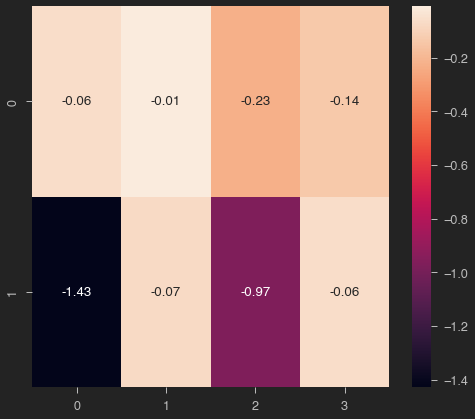

In [9]:
ax = sns.heatmap(np.vstack((a, a_standart)), annot=True, fmt=".2f",)

e) Find the partial $F$ for each variable, as in (8.26). Do the partial $F$’s rank the variables in the same order of importance as the standardized coefficients?

In [10]:
def calc_hotteling(data1, data2, n1, n2, p):
    mean1 = np.mean(data1, axis=0)
    mean2 = np.mean(data2, axis=0)

    engineers_cov = np.cov(data1, rowvar=False)
    pilots_cov = np.cov(data2, rowvar=False)
    
    S = ((n1 - 1) * engineers_cov + (n2 - 1) * pilots_cov) / (n1 + n2 - 2)
    
    T_2 = (mean1.T - mean2.T) @ np.linalg.pinv(S) @ (mean1 - mean2) * ((n1 * n2) / (n1 + n2))
    return T_2

In [11]:
def compute_f_stat(data1, data2, m, n1, n2, p):
    nu = n1 + n2 - 2
    t2 = calc_hotteling(data1, data2, n1, n2, p)
    t2_p = calc_hotteling(np.delete(data1, m, axis=1), np.delete(data2, m, axis=1), n1, n2, p-1)
    return (nu - p + 1) * (t2 - t2_p) / (nu + t2_p)

In [12]:
for m in range(d1):
    F = compute_f_stat(data_group1, data_group2, m, n1, n2, d1)
    print(f'Partian F value: {F:.4}')

Partian F value: 3.332
Partian F value: 0.01024
Partian F value: 1.482
Partian F value: 0.001338


## Task 8.11

Using the fish data in Table 6.17, do the following:

+ (a) Find the eigenvectors of $E^{−1}H$.
+ (b) Carry out tests of significance for the discriminant functions and find the relative importance of each as in (8.13), $\lambda_i / \sum_j \lambda_j$ . Do these two proce-dures agree as to the number of important discriminant functions?
+ (c) Find the standardized coefficients and comment on the contribution of the variables to separation of groups.
+ (d) Find the partial $F$ for each variable, as in (8.28). Do they rank the variables in the same order as the standardized coefficients for the first discriminant function?
+ (e) Plot the first two discriminant functions for each observation and for the mean vectors.

In [3]:
data = np.loadtxt('T6_17_FISH.dat', dtype=float)
n, d = data[:, 1:].shape
data.shape

(36, 5)

In [4]:
unique_groups = sorted(np.unique(data[:, 0]))
k = len(unique_groups)
unique_groups

[1.0, 2.0, 3.0]

a) Find the eigenvectors of $E^{−1}H$.

In [5]:
def get_H(data, unique_groups, d):
    H = np.zeros(shape=(d, d))
    total_mean = np.mean(data[:, 1:], axis=0)[:, None]
    for group in unique_groups:
        group_data = data[data[:, 0] == group][:, 1:]
        n_i = group_data.shape[0]
        group_mean = np.mean(group_data, axis=0)[:, None]
        H += n_i * (group_mean - total_mean) @ (group_mean - total_mean).T
    return H

In [6]:
def get_E(data, unique_groups, d):
    E = np.zeros(shape=(d, d))
    for group in unique_groups:
        group_data = data[data[:, 0] == group][:, 1:]
        n_i, _ = group_data.shape
        group_mean = np.mean(group_data, axis=0)[:, None]
        for i in range(n_i):
            E += (group_data[i, :][:, None] - group_mean) @ (group_data[i, :][:, None] - group_mean).T
    return E

In [7]:
H = get_H(data, unique_groups, d)
E = get_E(data, unique_groups, d)

In [ ]:
# eig_values, eig_vectors = np.linalg.eigh(np.linalg.inv(E) @ H)
# eig_values = eig_values[::-1]
# eig_vectors = eig_vectors[::-1]
# rank = min(k-1, d)
# rank

In [34]:
eig_values, eig_vectors = np.linalg.eig(np.linalg.inv(E) @ H)
rank = min(k-1, d)
rank

2

In [35]:
eig_values

array([ 2.95147543e+00,  1.27324367e-01, -5.33911074e-17, -3.27122011e-17])

In [36]:
for i in range(rank):
    print(f'Eigenvalue {eig_values[i]:.3} -- Eigenvector {np.round(eig_vectors[i], 3)}')

Eigenvalue 2.95 -- Eigenvector [-0.032 -0.635  0.646 -0.243]
Eigenvalue 0.127 -- Eigenvector [-0.82   0.597 -0.239  0.039]


In [37]:
eig_vectors

array([[-0.03181703, -0.63526646,  0.64616371, -0.24265056],
       [-0.81967777,  0.59729861, -0.23924223,  0.03891308],
       [ 0.53294806,  0.48673081, -0.258678  , -0.5608211 ],
       [ 0.20756299, -0.05257385,  0.67699431,  0.79062391]])

In [38]:
a = eig_vectors[:rank,:]

b) Carry out tests of significance for the discriminant functions and find the relative importance of each as in (8.13), $\lambda_i / \sum_j \lambda_j$ . Do these two proce-dures agree as to the number of important discriminant functions?

In [39]:
eig_values[0] / (eig_values[0] + eig_values[1]), eig_values[1] / (eig_values[0] + eig_values[1])

(0.9586448047458143, 0.041355195254185774)

In [40]:
def compute_lambda(eig_vals, m):
    return np.prod(1 / (1 + eig_vals[m:]))

def compute_mu(eig_vals, n, d, k, m):
    return (n - 1 - 0.5 * (d + k)) * np.sum(np.log(1 + eig_vals[m:]))

def compute_f(eig_vals, n, d, k, m):
    t = np.sqrt((((d - m + 1) ** 2) * ((k - m) ** 2) - 4) / (((d - m + 1) ** 2) + ((k - m) ** 2) - 5))
    w = n - 1 - 0.5 * (d + k)
    df1 = (d - m + 1) * (k - m)
    df2 = w * t - 0.5 * ((d - m + 1) * (k - m) - 2)
    f_critic = stats.f.ppf(1 - alpha, df1, df2)
    L = compute_lambda(eig_vals, m-1)
    F = ((1 - L ** (1./t)) * df2) / (L ** (1./t) * df1)
    p_val = stats.f.sf(F, df1, df2)
    return F, f_critic, p_val

In [41]:
for m in range(rank):
    F, F_critic, p_val = compute_f(eig_values, n, d, k, m+1)
    print(f'Partian F value: {F:.4}; Critic F value: {F_critic:.4}; p-value: {p_val:.4}')

Partian F value: 8.329; Critic F value: 2.097; p-value: 1.609e-07
Partian F value: 1.316; Critic F value: 2.911; p-value: 0.2869


c) Find the standardized coefficients and comment on the contribution of the variables to separation of groups.

In [42]:
err = np.sqrt(np.diag(E))
err

array([3.66173911, 2.91204396, 3.40697813, 3.25051278])

In [43]:
a * err

array([[-0.11650566, -1.84992386,  2.20146565, -0.78873873],
       [-3.00144614,  1.73935981, -0.81509304,  0.12648748]])

d) Find the partial $F$ for each variable, as in (8.28). Do they rank the variables in the same order as the standardized coefficients for the first discriminant function?

In [44]:
def compute_lambda(E, H):
    return np.linalg.det(E) / np.linalg.det(E + H)


def compute_f_stat(data, E, H, m, n, d, k):
    ve = n - k
    vh = k - 1
    L = compute_lambda(E, H) / compute_lambda(get_E(np.delete(data, m+1, axis=1), unique_groups, d-1), get_H(np.delete(data, m+1, axis=1), unique_groups, d-1))
    return ((1 - L) * (ve - d + 1)) / (L * vh)

In [45]:
for m in range(d):
    F = compute_f_stat(data, E, H, m, n, d, k)
    print(f'Partian F value: {F:.4}')

Partian F value: 1.067
Partian F value: 20.98
Partian F value: 9.63
Partian F value: 1.228


e) Plot the first two discriminant functions for each observation and for the mean vectors.

In [46]:
z = data[:, 1:] @ a.T
z_mean = np.mean(data[:, 1:], axis=0) @ a.T

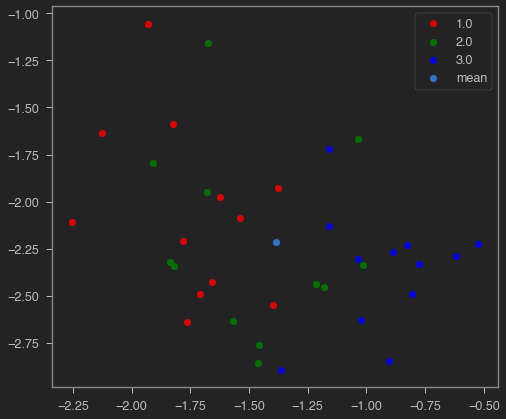

In [47]:
colors = ['red', 'green', 'blue']
for color, i, target_name in zip(colors, unique_groups, unique_groups):
    plt.scatter(z[data[:, 0] == i][:, 0], z[data[:, 0] == i][:, 1], alpha=.8, color=color, label=target_name)
plt.scatter(z_mean[0], z_mean[1], label='mean');
plt.legend();